In [ ]:
#These are the necessary imports for the project on machine learning and model training about Xray Abnormality Detection.
import os                                                           
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from tqdm import tqdm

In [ ]:
class MuraDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Thid MURA dataset folders are labeled 'Positive' and 'Negative' for abnormal and normal images respectively.
        for label, subfolder in enumerate(sorted(os.listdir(root_dir))):
            subfolder_path = os.path.join(root_dir, subfolder)
            for img_name in os.listdir(subfolder_path):
                self.images.append(os.path.join(subfolder_path, img_name))
                self.labels.append(label)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
from torch.utils.data import Dataset
import os
from PIL import Image

class MURADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Each study folder name ends with "_positive" or "_negative"
        for bodypart in os.listdir(root_dir):
            bodypart_path = os.path.join(root_dir, bodypart)

            if not os.path.isdir(bodypart_path):
                continue

            for patient in os.listdir(bodypart_path):
                patient_path = os.path.join(bodypart_path, patient)

                for study in os.listdir(patient_path):
                    study_path = os.path.join(patient_path, study)

                    label = 1 if "positive" in study.lower() else 0

                    for img_name in os.listdir(study_path):
                        img_path = os.path.join(study_path, img_name)

                        # Add only image files
                        # Skip MacOS junk files like ._image.png
                        if img_name.startswith("._"):
                            continue
                        if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                            self.image_paths.append(img_path)
                            self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label


In [5]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = train_transform  # same for validation


In [6]:
train_dataset = MURADataset(
    root_dir=r"E:\MURA Training\MURA-v1.1\train",
    transform=train_transform
)
val_dataset = MURADataset(
    root_dir=r"E:\MURA Training\MURA-v1.1\valid",
    transform=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=15, shuffle=False, num_workers=0)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_model(model_name):
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 2) 
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, 2)
    return model.to(device)


In [8]:
def train_model(model, train_loader, val_loader, epochs=5, lr=1e-4, model_name='model'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_acc = 0
    history = {'train_acc': [], 'val_acc': []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")
        
        # Compute training accuracy
        model.eval()
        train_correct = 0
        train_total = 0
        with torch.no_grad():
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, 1)
                train_total += labels.size(0)
                train_correct += (preds == labels).sum().item()
        train_acc = train_correct / train_total
        history['train_acc'].append(train_acc)
        
        # Validation accuracy
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(all_labels, all_preds)
        history['val_acc'].append(val_acc)
        
        print(f"Training Accuracy: {train_acc:.4f} | Validation Accuracy: {val_acc:.4f}")
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'checkpoints/{model_name}_best.pth')
            
    print("Training Done!")
    return history


In [ ]:
# ResNet50
resnet_model = get_model('resnet50')
resnet_history = train_model(resnet_model, train_loader, val_loader, epochs=20, model_name='resnet50')
# DenseNet121
densenet_model = get_model('densenet121')
densenet_history = train_model(densenet_model, train_loader, val_loader, epochs=20, model_name='densenet121')

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 71%|███████   | 1737/2454 [16:17<03:52,  3.09it/s]  

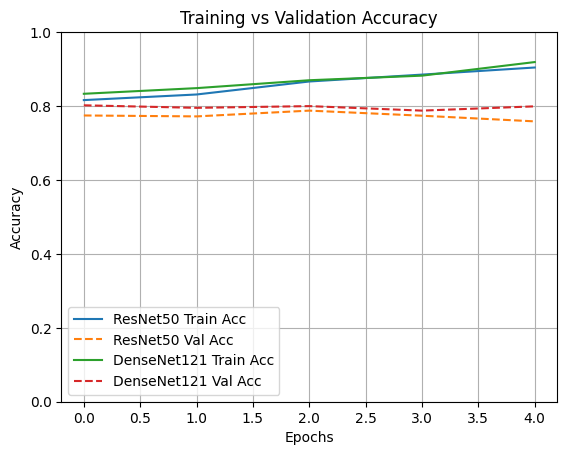

In [ ]:
import matplotlib.pyplot as plt

plt.plot(resnet_history['train_acc'], label='ResNet50 Train Acc', linestyle='-')
plt.plot(resnet_history['val_acc'], label='ResNet50 Val Acc', linestyle='--')
plt.plot(densenet_history['train_acc'], label='DenseNet121 Train Acc', linestyle='-')
plt.plot(densenet_history['val_acc'], label='DenseNet121 Val Acc', linestyle='--')

plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    preds = []
    labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images, targets = images.to(device), targets.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == targets).sum().item()
            total += targets.size(0)

            preds.extend(predicted.cpu().numpy())
            labels.extend(targets.cpu().numpy())

    accuracy = correct / total
    cm = confusion_matrix(labels, preds)
    return accuracy, cm


In [ ]:
resnet_model.load_state_dict(torch.load('checkpoints/resnet50_best.pth'))
densenet_model.load_state_dict(torch.load('checkpoints/densenet121_best.pth'))

resnet_acc, resnet_cm = evaluate_model(resnet_model, val_loader)
densenet_acc, densenet_cm = evaluate_model(densenet_model, val_loader)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17012\1102625367.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load('checkpoints/resnet50